In [1]:
# !pip install wandb

In [2]:
import wandb

In [3]:
wandb.login()

wandb: Currently logged in as: abhijeet001. Use `wandb login --relogin` to force relogin


True

In [4]:
# %%writefile activation.py
# ACTIVATION

import numpy as np
import math

def sigmoid_element_wise(vector_component):
    """
    Calculate the sigmoid function value of a component of a vector.

    Args:
    vector_component (float): The input value.

    Returns:
    float: The sigmoid value of the input.
    """
    if vector_component >= 0:
        return 1 / (1 + math.exp(-vector_component))
    else:
        return math.exp(vector_component) / (math.exp(vector_component) + 1)

def sigmoid(pre_activation_vector):
    """
    Calculate the sigmoid of a pre-activation layer.

    Args:
    pre_activation_vector (numpy.ndarray): The input vector.

    Returns:
    numpy.ndarray: The activated vector.
    """
    activated_vector = np.empty_like(pre_activation_vector)
    for i, elem in np.ndenumerate(pre_activation_vector):
        activated_vector[i] = sigmoid_element_wise(elem)
    return activated_vector

def softmax(pre_activation_vector):
    """
    Calculate the softmax of a pre-activation vector.

    Args:
    pre_activation_vector (numpy.ndarray): The input vector.

    Returns:
    numpy.ndarray: The softmax output.
    """
    post_act = np.copy(pre_activation_vector)
    max_exponent = np.max(post_act)
    post_act = np.exp(post_act - max_exponent)
    post_act = post_act / np.sum(post_act)
    return post_act

def relu(pre_activation_vector):
    """
    Calculate the ReLU activation of a pre-activation vector.

    Args:
    pre_activation_vector (numpy.ndarray): The input vector.

    Returns:
    numpy.ndarray: The ReLU activated vector.
    """
    post_act = np.copy(pre_activation_vector)
    post_act[post_act < 0] = 0
    return post_act

def activation_function(pre_activation_vector, context):
    """
    Apply the specified activation function to the pre-activation vector.

    Args:
    pre_activation_vector (numpy.ndarray): The input vector.
    context (str): The context specifying the activation function ('softmax', 'sigmoid', 'tanh', 'relu').

    Returns:
    numpy.ndarray: The activated vector.
    """
    if context == 'softmax':
        return softmax(pre_activation_vector)
    elif context == 'sigmoid':
        return sigmoid(pre_activation_vector)
    elif context == 'tanh':
        return np.copy(np.tanh(pre_activation_vector))
    elif context == 'relu':
        return relu(pre_activation_vector)
    else:
        return None


In [5]:
# %%writefile loss.py
# LOSS

"""This file contains various methods for calculating loss functions."""
import numpy as np

def cross_entropy(label, softmax_output):
    """
    Calculate the cross-entropy loss.

    Args:
    label (int): The true label index.
    softmax_output (numpy.ndarray): The softmax output vector.

    Returns:
    float: The cross-entropy loss.
    """
    if softmax_output[label] < 1e-8:
        return -np.log(1e-8)
    return -np.log(softmax_output[label])

def squared_error(label, softmax_output):
    """
    Calculate the squared error loss.

    Args:
    label (int): The true label index.
    softmax_output (numpy.ndarray): The softmax output vector.

    Returns:
    float: The squared error loss.
    """
    true_vector = np.zeros_like(softmax_output)
    true_vector[label] = 1
    size = float(len(softmax_output))
    return np.array([(np.linalg.norm(true_vector - softmax_output) ** 2) / size]).reshape((1, 1))

# import numpy as np


# # calculate cross entropy
# def cross_entropy(label, softmax_output):
#     # as we have only one true label, we have simplified the function for faster calculation.
#     if softmax_output[label] < 10 ** -8:
#         return -np.log(10 ** -8)
#     return -np.log(softmax_output[label])


# def squared_error(label, softmax_output):
#     true_vector = np.zeros_like(softmax_output)
#     true_vector[label] = 1
#     size = float(len(softmax_output))
#     return np.array([(np.linalg.norm(true_vector - softmax_output) ** 2) / size]).reshape((1, 1))


In [6]:
# %%writefile grad.py
# GRAD

import numpy as np

def cross_entropy_grad(y_hat, label):
    """
    Calculate the gradient of cross-entropy loss with respect to the output activations.

    Args:
    y_hat (numpy.ndarray): The predicted output vector.
    label (int): The true label index.

    Returns:
    numpy.ndarray: The gradient of the loss with respect to the output activations.
    """
    temp = np.zeros_like(y_hat)
    if y_hat[label] < 1e-8:
        y_hat[label] = 1e-8
    temp[label] = -1 / (y_hat[label])
    norm = np.linalg.norm(temp)
    if norm > 100.0:
        return temp * 100.0 / norm
    else:
        return temp

def squared_error_grad(y_hat, label):
    """
    Calculate the gradient of squared error loss with respect to the output activations.

    Args:
    y_hat (numpy.ndarray): The predicted output vector.
    label (int): The true label index.

    Returns:
    numpy.ndarray: The gradient of the loss with respect to the output activations.
    """
    temp = np.copy(y_hat)
    temp[label] -= 1
    temp = 2 * temp / len(y_hat)
    norm = np.linalg.norm(temp)
    if norm > 100.0:
        return temp * 100.0 / norm
    else:
        return temp

def output_grad(y_hat, label, loss_type):
    """
    Calculate the gradient of the specified loss function with respect to the output activations.

    Args:
    y_hat (numpy.ndarray): The predicted output vector.
    label (int): The true label index.
    loss_type (str): The type of loss function ('cross_entropy' or 'squared_error').

    Returns:
    numpy.ndarray: The gradient of the loss with respect to the output activations.
    """
    if loss_type == 'cross_entropy':
        return cross_entropy_grad(y_hat, label)
    elif loss_type == 'squared_error':
        return squared_error_grad(y_hat, label)

def last_grad(y_hat, label):
    """
    Calculate the gradient of the last layer's activations with respect to the output activations.

    Args:
    y_hat (numpy.ndarray): The predicted output vector.
    label (int): The true label index.

    Returns:
    numpy.ndarray: The gradient of the last layer's activations with respect to the output activations.
    """
    temp = np.copy(y_hat)
    temp[label] = temp[label] - 1
    norm = np.linalg.norm(temp)
    if norm > 100.0:
        return temp * 100.0 / norm
    else:
        return temp

def sigmoid_grad(post_activation):
    """
    Calculate the gradient of the sigmoid activation function.

    Args:
    post_activation (numpy.ndarray): The post-activation vector.

    Returns:
    numpy.ndarray: The gradient of the sigmoid activation function.
    """
    return np.multiply(post_activation, 1 - post_activation)

def tanh_grad(post_activation):
    """
    Calculate the gradient of the hyperbolic tangent activation function.

    Args:
    post_activation (numpy.ndarray): The post-activation vector.

    Returns:
    numpy.ndarray: The gradient of the hyperbolic tangent activation function.
    """
    return 1 - np.power(post_activation, 2)

def relu_grad(pre_activation_vector):
    """
    Calculate the gradient of the ReLU activation function.

    Args:
    pre_activation_vector (numpy.ndarray): The pre-activation vector.

    Returns:
    numpy.ndarray: The gradient of the ReLU activation function.
    """
    grad = np.copy(pre_activation_vector)
    grad[grad >= 0] = 1
    grad[grad < 0] = 0
    return grad

def a_grad(network, transient_gradient, layer):
    """
    Calculate the gradient of the activation values with respect to the pre-activation values.

    Args:
    network (list): The network configuration.
    transient_gradient (dict): The transient gradients.
    layer (int): The layer index.

    Returns:
    numpy.ndarray: The gradient of the activation values with respect to the pre-activation values.
    """
    if network[layer]['context'] == 'sigmoid':
        active_grad_ = sigmoid_grad(network[layer]['h'])
    elif network[layer]['context'] == 'tanh':
        active_grad_ = tanh_grad(network[layer]['h'])
    elif network[layer]['context'] == 'relu':
        active_grad_ = relu_grad(network[layer]['a'])
    temp = np.multiply(transient_gradient[layer]['h'], active_grad_)
    norm = np.linalg.norm(temp)
    if norm > 100.0:
        return temp * 100.0 / norm
    else:
        return temp

def h_grad(network, transient_gradient, layer):
    """
    Calculate the gradient of the hidden layer activations with respect to the pre-activation values.

    Args:
    network (list): The network configuration.
    transient_gradient (dict): The transient gradients.
    layer (int): The layer index.

    Returns:
    numpy.ndarray: The gradient of the hidden layer activations with respect to the pre-activation values.
    """
    network[layer]['weight'].transpose()
    temp = network[layer + 1]['weight'].transpose() @ transient_gradient[layer + 1]['a']
    norm = np.linalg.norm(temp)
    if norm > 100.0:
        return temp * 100.0 / norm
    else:
        return temp

def w_grad(network, transient_gradient, layer, x):
    """
    Calculate the gradient of the weights with respect to the pre-activation values.

    Args:
    network (list): The network configuration.
    transient_gradient (dict): The transient gradients.
    layer (int): The layer index.
    x (numpy.ndarray): The input vector.

    Returns:
    numpy.ndarray: The gradient of the weights with respect to the pre-activation values.
    """
    if layer == 0:
        temp = transient_gradient[layer]['a'] @ x.transpose()
    else:
        temp = transient_gradient[layer]['a'] @ network[layer - 1]['h'].transpose()
    norm = np.linalg.norm(temp)
    if norm > 10000.0:
        return temp * 10000.0 / norm
    else:
        return temp


In [7]:
# %%writefile optimiser.py
# OPTIMISER

import sys
import copy
import math
import numpy as np


class SimpleGradientDescent:
    """
    Class for simple gradient descent optimiser.

    Attributes:
    eta (float): Learning rate.
    layers (int): Number of layers in the network.
    weight_decay (float): Weight decay coefficient.
    calls (int): Number of optimiser calls.
    lrc (float): Learning rate controller.
    """

    def __init__(self, eta, layers, weight_decay=0.0):
        self.eta = eta
        self.layers = layers
        self.calls = 1
        self.lrc = 1.0
        self.weight_decay = weight_decay

    def descent(self, network, gradient):
        for i in range(self.layers):
            network[i]['weight'] = network[i]['weight'] - ((self.eta / self.lrc) * gradient[i]['weight']) - (
                        self.eta * self.weight_decay * network[i]['weight'])
            network[i]['bias'] -= ((self.eta / self.lrc) * gradient[i]['bias'])
        self.calls += 1
        if self.calls % 10 == 0:
            self.lrc += 1.0

class MomentumGradientDescent:
    """
    Class for Momentum gradient descent optimiser.

    Attributes:
    eta (float): Learning rate.
    gamma (float): Momentum coefficient.
    layers (int): Number of layers in the network.
    weight_decay (float): Weight decay coefficient.
    calls (int): Number of optimiser calls.
    lrc (float): Learning rate controller.
    momentum (dict): Historical momentum.
    """

    def __init__(self, eta, layers, gamma, weight_decay=0.0):
        self.eta = eta
        self.gamma = gamma
        self.layers = layers
        self.calls = 1
        self.lrc = 1
        self.momentum = None
        self.weight_decay = weight_decay

    def descent(self, network, gradient):
        gamma = min(1 - 2 ** (-1 - math.log((self.calls / 250.0) + 1, 2)), self.gamma)

        if self.momentum is None:
            self.momentum = copy.deepcopy(gradient)
            for i in range(self.layers):
                self.momentum[i]['weight'] = (self.eta / self.lrc) * gradient[i]['weight']
                self.momentum[i]['bias'] = (self.eta / self.lrc) * gradient[i]['bias']
        else:
            for i in range(self.layers):
                self.momentum[i]['weight'] = gamma * self.momentum[i]['weight'] + (self.eta / self.lrc) * gradient[i][
                    'weight']
                self.momentum[i]['bias'] = gamma * self.momentum[i]['bias'] + (self.eta / self.lrc) * gradient[i][
                    'bias']
        for i in range(self.layers):
            network[i]['weight'] = network[i]['weight'] - self.momentum[i]['weight'] - (
                        (self.eta / self.lrc) * self.weight_decay * network[i]['weight'])
            network[i]['bias'] -= self.momentum[i]['bias']

        self.calls += 1
        if self.calls % 10 == 0:
            self.lrc += 1.0

class NAG:
    """
    Class for Nesterov Accelerated Gradient (NAG) optimiser.

    Attributes:
    eta (float): Learning rate.
    gamma (float): NAG coefficient.
    layers (int): Number of layers in the network.
    weight_decay (float): Weight decay coefficient.
    calls (int): Number of optimiser calls.
    momentum (dict): Historical momentum.
    lrc (float): Learning rate controller.
    """

    def __init__(self, eta, layers, gamma, weight_decay=0.0):
        self.eta = eta
        self.gamma = gamma
        self.layers = layers
        self.calls = 1
        self.momentum = None
        self.lrc = 1.0
        self.weight_decay = weight_decay

    def lookahead(self, network):
        if self.momentum is None:
            pass
        else:
            for i in range(self.layers):
                network[i]['weight'] -= self.gamma * self.momentum[i]['weight']
                network[i]['bias'] -= self.gamma * self.momentum[i]['bias']

    def descent(self, network, gradient):
        for i in range(self.layers):
            network[i]['weight'] = network[i]['weight'] - ((self.eta / self.lrc) * gradient[i]['weight']) - (
                        (self.eta / self.lrc) * self.weight_decay * network[i]['weight'])
            network[i]['bias'] -= self.eta * gradient[i]['bias']

        gamma = min(1 - 2 ** (-1 - math.log((self.calls / 250.0) + 1, 2)), self.gamma)

        if self.momentum is None:
            self.momentum = copy.deepcopy(gradient)
            for i in range(self.layers):
                self.momentum[i]['weight'] = (self.eta / self.lrc) * gradient[i]['weight']
                self.momentum[i]['bias'] = (self.eta / self.lrc) * gradient[i]['bias']
        else:
            for i in range(self.layers):
                self.momentum[i]['weight'] = gamma * self.momentum[i]['weight'] + ((self.eta / self.lrc) * gradient[i][
                    'weight'])
                self.momentum[i]['bias'] = gamma * self.momentum[i]['bias'] + ((self.eta / self.lrc) * gradient[i][
                    'bias'])

        self.calls += 1
        if self.calls % 10 == 0:
            self.lrc += 1.0

class RMSProp:
    """
    Class for RMSProp optimiser.

    Attributes:
    eta (float): Learning rate.
    beta (float): Decay parameter for denominator.
    layers (int): Number of layers in the network.
    calls (int): Number of optimiser calls.
    epsilon (float): Epsilon value.
    update (dict): Update rule for RMSProp.
    weight_decay (float): Weight decay coefficient.
    """

    def __init__(self, eta, layers, beta, weight_decay=0.0):
        self.eta = eta
        self.beta = beta
        self.layers = layers
        self.calls = 1
        self.epsilon = 0.001
        self.update = None
        self.weight_decay = weight_decay

    def descent(self, network, gradient):
        if self.update is None:
            self.update = copy.deepcopy(gradient)
            for i in range(self.layers):
                self.update[i]['weight'] = (1 - self.beta) * (gradient[i]['weight']) ** 2
                self.update[i]['bias'] = (1 - self.beta) * (gradient[i]['bias']) ** 2
        else:
            for i in range(self.layers):
                self.update[i]['weight'] = self.beta * self.update[i]['weight'] + (1 - self.beta) * (gradient[i][
                    'weight']) ** 2
                self.update[i]['bias'] = self.beta * self.update[i]['bias'] + (1 - self.beta) * (
                    gradient[i]['bias']) ** 2

        for i in range(self.layers):
            network[i]['weight'] = network[i]['weight'] - np.multiply(
                (self.eta / np.sqrt(self.update[i]['weight'] + self.epsilon)),
                gradient[i]['weight']) - self.weight_decay * network[i]['weight']
            network[i]['bias'] = network[i]['bias'] - np.multiply(
                (self.eta / np.sqrt(self.update[i]['bias'] + self.epsilon)), gradient[i]['bias'])

        self.calls += 1

class ADAM:
    """
    Class for ADAM optimiser.

    Attributes:
    eta (float): Learning rate.
    layers (int): Number of layers in the network.
    weight_decay (float): Weight decay coefficient.
    beta1 (float): Exponential decay rate for the first moment estimates.
    beta2 (float): Exponential decay rate for the second moment estimates.
    eps (float): Epsilon value.
    calls (int): Number of optimiser calls.
    momentum (dict): First moment vector.
    t_momentum (dict): Biased corrected first moment vector.
    second_momentum (dict): Second moment vector.
    t_second_momentum (dict): Biased corrected second moment vector.
    """

    def __init__(self, eta, layers, weight_decay=0.0, beta1=0.9, beta2=0.999, eps=1e-8):
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.layers = layers
        self.calls = 1
        self.momentum = None
        self.t_momentum = None
        self.second_momentum = None
        self.t_second_momentum = None
        self.eps = eps
        self.weight_decay = weight_decay

    def descent(self, network, gradient):
        if self.momentum is None:
            self.momentum = copy.deepcopy(gradient)
            self.second_momentum = copy.deepcopy(gradient)
            for i in range(self.layers):
                self.momentum[i]['weight'][:] = np.zeros_like(gradient[i]['weight'])
                self.momentum[i]['bias'][:] = np.zeros_like(gradient[i]['bias'])
                self.second_momentum[i]['weight'][:] = np.zeros_like(gradient[i]['weight'])
                self.second_momentum[i]['bias'][:] = np.zeros_like(gradient[i]['bias'])
            self.t_momentum = copy.deepcopy(self.momentum)
            self.t_second_momentum = copy.deepcopy(self.second_momentum)

        for i in range(self.layers):
            self.momentum[i]['weight'] = self.beta1 * self.momentum[i]['weight'] + (1 - self.beta1) * gradient[i][
                'weight']
            self.momentum[i]['bias'] = self.beta1 * self.momentum[i]['bias'] + (1 - self.beta1) * gradient[i]['bias'
            ]

            self.second_momentum[i]['weight'] = self.beta2 * self.second_momentum[i]['weight'] + (
                    1 - self.beta2) * np.power(gradient[i][
                                                   'weight'], 2)
            self.second_momentum[i]['bias'] = self.beta2 * self.second_momentum[i]['bias'] + (
                    1 - self.beta2) * np.power(gradient[i]['bias'
                                               ], 2)

        for i in range(self.layers):
            self.t_momentum[i]['weight'][:] = (1 / (1 - (self.beta1 ** self.calls))) * self.momentum[i]['weight']
            self.t_momentum[i]['bias'][:] = (1 / (1 - (self.beta1 ** self.calls))) * self.momentum[i]['bias']

            self.t_second_momentum[i]['weight'][:] = (1 / (1 - (self.beta2 ** self.calls))) * \
                                                     self.second_momentum[i][
                                                         'weight']
            self.t_second_momentum[i]['bias'][:] = (1 / (1 - (self.beta2 ** self.calls))) * self.second_momentum[i][
                'bias']

        for i in range(self.layers):
            temp = np.sqrt(self.t_second_momentum[i]['weight'])
            temp_eps = temp + self.eps
            temp_inv = 1 / temp_eps
            network[i]['weight'] = network[i]['weight'] - self.eta * (
                np.multiply(temp_inv, self.t_momentum[i]['weight'])) - (
                                               self.eta * self.weight_decay * network[i]['weight'])

            temp = np.sqrt(self.t_second_momentum[i]['bias'])
            temp_eps = temp + self.eps
            temp_inv = 1 / temp_eps
            network[i]['bias'] -= self.eta * np.multiply(temp_inv, self.t_momentum[i]['bias'])

        self.calls += 1

class NADAM:
    """
    Class for Nesterov Accelerated ADAM (NADAM) optimiser.

    Attributes:
    eta (float): Learning rate.
    layers (int): Number of layers in the network.
    weight_decay (float): Weight decay coefficient.
    beta1 (float): Exponential decay rate for the first moment estimates.
    beta2 (float): Exponential decay rate for the second moment estimates.
    eps (float): Epsilon value.
    calls (int): Number of optimiser calls.
    momentum (dict): First moment vector.
    second_momentum (dict): Second moment vector.
    """

    def __init__(self, eta, layers, weight_decay=0.0, beta1=0.9, beta2=0.999, eps=1e-8):
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.layers = layers
        self.calls = 1
        self.momentum = None
        self.second_momentum = None
        self.eps = eps
        self.weight_decay = weight_decay

    def descent(self, network, gradient):
        if self.momentum is None:
            self.momentum = copy.deepcopy(gradient)
            self.second_momentum = copy.deepcopy(gradient)
            for i in range(self.layers):
                self.momentum[i]['weight'] = (1 - self.beta1) * gradient[i]['weight']
                self.momentum[i]['bias'] = (1 - self.beta1) * gradient[i]['bias']
                self.second_momentum[i]['weight'] = (1 - self.beta2) * np.power(gradient[i]['weight'], 2)
                self.second_momentum[i]['bias'] = (1 - self.beta2) * np.power(gradient[i]['bias'], 2)
        else:
            for i in range(self.layers):
                self.momentum[i]['weight'] = self.beta1 * self.momentum[i]['weight'] + (1 - self.beta1) * \
                                             gradient[i][
                                                 'weight']
                self.momentum[i]['bias'] = self.beta1 * self.momentum[i]['bias'] + (1 - self.beta1) * gradient[i][
                    'bias'
                ]
                self.second_momentum[i]['weight'] = self.beta2 * self.second_momentum[i]['weight'] + (
                        1 - self.beta2) * np.power(gradient[i][
                                                       'weight'], 2)
                self.second_momentum[i]['bias'] = self.beta2 * self.second_momentum[i]['bias'] + (
                        1 - self.beta2) * np.power(gradient[i]['bias'
                                                   ], 2)

        m_t_hat = copy.deepcopy(self.momentum)
        v_t_hat = copy.deepcopy(self.second_momentum)
        for i in range(self.layers):
            m_t_hat[i]['weight'] = (self.beta1 / (1 - (self.beta1 ** self.calls))) * self.momentum[i][
                'weight'] + ((1 - self.beta1) / (1 - (self.beta1 ** self.calls))) * gradient[i]['weight']
            m_t_hat[i]['bias'] = (self.beta1 / (1 - (self.beta1 ** self.calls))) * self.momentum[i]['bias'] + (
                    (1 - self.beta1) / (1 - (self.beta1 ** self.calls))) * gradient[i]['bias']

            v_t_hat[i]['weight'] = (self.beta2 / (1 - (self.beta2 ** self.calls))) * \
                                   self.second_momentum[i][
                                       'weight']
            v_t_hat[i]['bias'] = (self.beta2 / (1 - (self.beta2 ** self.calls))) * self.second_momentum[i][
                'bias']

        for i in range(self.layers):
            temp = np.sqrt(self.second_momentum[i]['weight'] + self.eps)
            temp_inv = 1 / temp
            network[i]['weight'] = network[i]['weight'] - self.eta * (
                np.multiply(temp_inv, m_t_hat[i]['weight'])) - (self.eta * self.weight_decay * network[i]['weight'])

            temp = np.sqrt(self.second_momentum[i]['bias']) + self.eps
            temp_inv = 1 / temp
            network[i]['bias'] -= self.eta * np.multiply(temp_inv, v_t_hat[i]['bias'])

        self.calls += 1


In [8]:
############################################################################################################################
# %%writefile main.py
# Main

"""Implement Feed Forward neural network where the parameters are
   number of hidden layers and number of neurons in each hidden layer"""
# from loss import *
# from grad import *
# from activation import *
# from optimiser import *
import copy
from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import wandb

""" get training and testing vectors
    Number of Training Images = 60000
    Number of Testing Images = 10000 """
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

last = 2
# network is a list of all the learning parameters in every layer and gradient is its copy
network = []
gradient = []
# store gradient w.r.t a single datapoint
transient_gradient = []
# will contain the total amount of loss for each timestep(1). One timestep is defined as one update of the parameters.
loss = 0


def forward_propagation(n, x):
    for i in range(n):
        if i == 0:
            network[i]['a'] = network[i]['weight'] @ x + network[i]['bias']
        else:
            network[i]['a'] = network[i]['weight'] @ network[i - 1]['h'] + network[i]['bias']

        network[i]['h'] = activation_function(network[i]['a'], context=network[i]['context'])


def backward_propagation(number_of_layers, x, y, number_of_datapoint, loss_type, clean=False):
    transient_gradient[number_of_layers - 1]['h'] = output_grad(network[number_of_layers - 1]['h'], y,
                                                                loss_type=loss_type)
    transient_gradient[number_of_layers - 1]['a'] = last_grad(network[number_of_layers - 1]['h'], y)
    for i in range(number_of_layers - 2, -1, -1):
        transient_gradient[i]['h'] = h_grad(network=network, transient_gradient=transient_gradient, layer=i)
        transient_gradient[i]['a'] = a_grad(network=network, transient_gradient=transient_gradient, layer=i)
    for i in range(number_of_layers - 1, -1, -1):
        transient_gradient[i]['weight'] = w_grad(network=network, transient_gradient=transient_gradient, layer=i, x=x)
        transient_gradient[i]['bias'] = gradient[i]['a']
    if clean:
        gradient[number_of_layers - 1]['h'] = transient_gradient[number_of_layers - 1]['h'] / float(number_of_datapoint)
        gradient[number_of_layers - 1]['a'] = transient_gradient[number_of_layers - 1]['a'] / float(number_of_datapoint)
        for i in range(number_of_layers - 2, -1, -1):
            gradient[i]['h'] = transient_gradient[i]['h'] / float(number_of_datapoint)
            gradient[i]['a'] = transient_gradient[i]['a'] / float(number_of_datapoint)
        for i in range(number_of_layers - 1, -1, -1):
            gradient[i]['weight'] = transient_gradient[i]['weight'] / float(number_of_datapoint)
            gradient[i]['bias'] = transient_gradient[i]['bias'] / float(number_of_datapoint)
    else:

        gradient[number_of_layers - 1]['h'] += transient_gradient[number_of_layers - 1]['h'] / float(
            number_of_datapoint)
        gradient[number_of_layers - 1]['a'] += transient_gradient[number_of_layers - 1]['a'] / float(
            number_of_datapoint)
        for i in range(number_of_layers - 2, -1, -1):
            gradient[i]['h'] += transient_gradient[i]['h'] / float(number_of_datapoint)
            gradient[i]['a'] += transient_gradient[i]['a'] / float(number_of_datapoint)
        for i in range(number_of_layers - 1, -1, -1):
            gradient[i]['weight'] += transient_gradient[i]['weight'] / float(number_of_datapoint)
            gradient[i]['bias'] += transient_gradient[i]['bias'] / float(number_of_datapoint)


# this function is used for validation, useful during hyperparameter tuning or model change.
def validate(number_of_layer, validateX, validateY, loss_type):
    loss_local = 0
    acc = 0
    if loss_type == 'cross_entropy':
        for x, y in zip(validateX, validateY):
            forward_propagation(number_of_layer, x.reshape(784, 1) / 255.0)
            # adding loss w.r.t to a single datapoint
            loss_local += cross_entropy(label=y, softmax_output=network[number_of_layer - 1]['h'])
            max_prob = np.argmax(network[number_of_layer - 1]['h'])
            if max_prob == y:
                acc += 1
    elif loss_type == 'squared_error':
        for x, y in zip(validateX, validateY):
            forward_propagation(number_of_layer, x.reshape(784, 1) / 255.0)
            # adding loss w.r.t to a single datapoint
            loss_local += squared_error(label=y, softmax_output=network[number_of_layer - 1]['h'])
            max_prob = np.argmax(network[number_of_layer - 1]['h'])
            if max_prob == y:
                acc += 1
    average_loss = loss_local / float(len(validateX))
    acc = acc / float(len(validateX))
    return [average_loss, acc]


def augment_my_data(datapoints, labels, d, newSize):
    dataGenerator = ImageDataGenerator(rotation_range=15, shear_range=0.1, zoom_range=0.2, width_shift_range=0.1,
                                       height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest')
    new_data = []
    new_label = []
    datapoints = datapoints.reshape((d, 28, 28, 1))
    i = 0
    for (data, label) in dataGenerator.flow(datapoints, labels, batch_size=1):
        new_data.append(data.reshape(28, 28))
        new_label.append(label)
        i += 1
        if i > newSize:
            break

    return np.array(new_data), np.array(new_label), newSize


# 1 epoch = 1 pass over the data
def fit(datapoints, batch, epochs, labels, opt, loss_type, augment):
    n = len(network)  # number of layers
    d = len(datapoints)  # number of data points
    """This variable will be used to separate , training and validation set
        1) we take 10 % of the data as suggested in the question. -->int(d * .1)
        2) we also add any extra remaining data to validation set so that,
        training data is exactly divisible by batch size -->((d - int(d * .1)) % batch
    """
    border = d - ((d - int(d * .1)) % batch + int(d * .1))
    # separating the validation data
    validateX = datapoints[border:]
    validateY = labels[border:]
    # deleting copied datapoints
    datapoints = datapoints[:border]
    labels = labels[:border]
    # updating d
    d = border
    # augmenting my datapoints
    if augment is not None:
        (datapoints, labels, d) = augment_my_data(datapoints=datapoints, labels=labels, d=d, newSize=d + augment * batch)

    # is used to stochastically select our data.
    shuffler = np.arange(0, d)
    # creating simple gradient descent optimiser

    # loop for epoch iteration
    for k in range(epochs):
        # iteration for different starting point for epoch
        # shuffler at the start of each epoch
        np.random.shuffle(shuffler)
        for i in range(0, d - batch + 1, batch):
            clean = True
            # initiating loss for current epoch
            global loss
            loss = 0
            if isinstance(opt, NAG):
                opt.lookahead(network=network)
            # iterate over a batch
            for j in range(i, i + batch, 1):
                # creating a single data vector and normalising color values between 0 to 1
                x = datapoints[shuffler[j]].reshape(784, 1) / 255.0
                y = labels[shuffler[j]]
                forward_propagation(n, x)

                backward_propagation(n, x, y, number_of_datapoint=batch, loss_type=loss_type, clean=clean)
                clean = False

            opt.descent(network=network, gradient=gradient)

        # for wandb logging
        validation_result = validate(number_of_layer=n, validateX=validateX, validateY=validateY,
                                     loss_type=loss_type)
        training_result = validate(number_of_layer=n, validateX=datapoints,
                                   validateY=labels, loss_type=loss_type)

        # printing average loss.
        wandb.log({"val_accuracy": validation_result[1], 'val_loss': validation_result[0][0],
                   'train_accuracy': training_result[1], 'train_loss': training_result[0][0], 'epochs': k + 1})  # EPOCH -> EPOCHES

        if np.isnan(validation_result[0])[0]:
            return


""" Adds a particular on top of previous layer , the layers are built in a incremental way.
    Context denotes the type of layer we have.Eg - Sigmoid or Tanh etc.
    Passing any number to input_dim it we counted as the first layer
 """


def add_layer(number_of_neurons, context, weight_init, input_dim=None):
    # Initialize an Empty Dictionary: layer
    layer = {}
    if weight_init == 'random':
        if input_dim is not None:
            layer['weight'] = np.random.rand(number_of_neurons, input_dim)
        else:
            # get number of neurons in the previous layer
            previous_lay_neuron_num = network[-1]['h'].shape[0]
            layer['weight'] = np.random.rand(number_of_neurons, previous_lay_neuron_num)

    elif weight_init == 'xavier':
        if input_dim is not None:
            layer['weight'] = np.random.normal(size=(number_of_neurons, input_dim))
            xavier = input_dim
        else:
            # get number of neurons in the previous layer
            previous_lay_neuron_num = network[-1]['h'].shape[0]
            layer['weight'] = np.random.normal(size=(number_of_neurons, previous_lay_neuron_num))
            xavier = previous_lay_neuron_num
        if context == 'relu':
            # relu has different optimal weight initialization.
            layer['weight'] = layer['weight'] * math.sqrt(2 / float(xavier))
        else:
            layer['weight'] = layer['weight'] * math.sqrt(1 / float(xavier))
    # initialise a 1-D array of size n with random samples from a uniform distribution over [0, 1).
    layer['bias'] = np.zeros((number_of_neurons, 1))
    # initialises a 2-D array of size [n*1] and type float with element having value as 1.
    layer['h'] = np.zeros((number_of_neurons, 1))
    layer['a'] = np.zeros((number_of_neurons, 1))
    layer['context'] = context
    network.append(layer)


"""master() is used to initialise all the learning parameters in every layer and then start the training process"""

def master(batch, epochs, output_dim, activation, opt, layer_1, layer_2, layer_3, weight_init='xavier',loss_type='cross_entropy',
           augment=None):
    
    """initializing number of input features per datapoint as 784, since dataset consists of 28x28 pixel grayscale images
       :param augment: """
    
    n_features = 784
    global network
    global gradient
    global transient_gradient
    network = []
    gradient = []
    transient_gradient = []
    # adding layers
    add_layer(number_of_neurons=layer_1, context=activation, input_dim=784, weight_init=weight_init)
    # creating hidden layers
    add_layer(number_of_neurons=layer_2, context=activation, weight_init=weight_init)
    add_layer(number_of_neurons=layer_3, context=activation, weight_init=weight_init)
    add_layer(number_of_neurons=output_dim, context='softmax', weight_init=weight_init)

    """Copying the structure of network."""
    gradient = copy.deepcopy(network)
    transient_gradient = copy.deepcopy(network)
    fit(datapoints=trainX, labels=trainY, batch=batch, epochs=epochs, opt=opt,
        loss_type=loss_type,augment=augment)
    return network


def train():
    run = wandb.init()
    opti = None
    
    # Overwrite the random run names chosen by wandb
    
    name_str = f'act:{run.config.activation}_opt:{run.config.optimiser}_bs:{run.config.batch_size}_winit:{run.config.weight_init}_epoc:{run.config.epochs}_numlayers:{run.config.num_layers}_l1:{run.config.layer_1}_l2:{run.config.layer_2}_l3:{run.config.layer_3}_lr:{run.config.learning_rate}_wtDec:{run.config.weight_decay}'

    run.name = name_str

    if run.config.optimiser == 'nag':
        opti = NAG(layers=4, eta=run.config.learning_rate, gamma=.90, weight_decay=run.config.weight_decay)
    elif run.config.optimiser == 'rmsprop':
        opti = RMSProp(layers=4, eta=run.config.learning_rate, beta=.90, weight_decay=run.config.weight_decay)
    elif run.config.optimiser == 'sgd':
        opti = SimpleGradientDescent(layers=4, eta=run.config.learning_rate, weight_decay=run.config.weight_decay)
    elif run.config.optimiser == 'mom':
        opti = MomentumGradientDescent(layers=4, eta=run.config.learning_rate, gamma=.99,
                                       weight_decay=run.config.weight_decay)
    elif run.config.optimiser == 'adam':
        opti = ADAM(layers=4, eta=run.config.learning_rate, weight_decay=run.config.weight_decay)
    elif run.config.optimiser == 'nadam':
        opti = NADAM(layers=4, eta=run.config.learning_rate, weight_decay=run.config.weight_decay)

    master(epochs=run.config.epochs, batch=run.config.batch_size, output_dim=10,
           opt=opti, weight_init=run.config.weight_init, activation=run.config.activation, layer_1=run.config.layer_1,
           layer_3=run.config.layer_3, layer_2=run.config.layer_2, loss_type=run.config.loss_type, augment=100)

    # exit intt # abhi
    wandb.finish()


In [9]:
# #############################################################################################################################
# # %%writefile save_model.py
# # from main import master, ADAM

import pickle
import wandb

# Initialize Wandb
wandb.init()

network = master(batch=495, epochs=7, output_dim=10, activation='tanh',
                 opt=ADAM(eta=0.003576466933615937, layers=4, weight_decay=0.31834976996809683),
                 layer_1=32, layer_2=64, layer_3=16, weight_init='xavier', loss_type='cross_entropy', augment=100)
print(len(network))
print(network)

filename_model = 'neural_network.object'
pickle.dump(network, open(filename_model, 'wb'))  # store best model's object to disk

# Finish Wandb run
wandb.finish()


4
[{'weight': array([[ 0.0373841 ,  0.04857826,  0.09449899, ...,  0.05460617,
         0.04904008,  0.07978741],
       [ 0.14243137,  0.30002044,  0.46305362, ...,  0.08164669,
         0.05892919,  0.18590315],
       [ 0.04281479,  0.04045966,  0.08990568, ..., -0.0393886 ,
         0.00092231, -0.0924676 ],
       ...,
       [ 0.10236519,  0.08169193,  0.00981851, ..., -0.0680689 ,
        -0.0593478 , -0.13850232],
       [ 0.10232502, -0.08803875, -0.04090767, ...,  0.02657535,
        -0.02546747, -0.0216591 ],
       [-0.01571384,  0.0669532 ,  0.02612046, ...,  0.10309487,
         0.120604  ,  0.04690811]]), 'bias': array([[ 0.33005591],
       [ 0.07049532],
       [ 0.3756697 ],
       [ 0.05127374],
       [-0.1985226 ],
       [-0.47221445],
       [ 0.47869419],
       [-0.23956301],
       [-0.30509509],
       [-0.25608833],
       [ 0.44608339],
       [ 0.10106495],
       [ 0.13777892],
       [ 0.40493772],
       [-0.20039625],
       [ 0.4256552 ],
       [-0.7

epochs,▁▂▃▅▆▇█
train_accuracy,▁▅▆▆▇▇█
train_loss,█▄▃▂▂▂▁
val_accuracy,▁▄▅▆▇▆█
val_loss,█▄▃▂▁▂▁
epochs,7
train_accuracy,0.7461
train_loss,0.68102
val_accuracy,0.79735
val_loss,0.57221


Accuracy:  78.39 %
            Top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  Sneaker  Bag  \
Top         831       13        16     68     3       3     53        0   13   
Trouser       6      945        11     30     4       0      2        0    2   
Pullover     11        2       756      6   116       0    104        0    5   
Dress        87       21        10    736    66       0     75        0    4   
Coat          5        2       240     20   662       0     66        0    5   
Sandal        1        0         0      1     0     911      0       50    3   
Shirt       265        4       270     41    96       0    298        0   26   
Sneaker       0        0         0      0     0      66      0      798    0   
Bag           1        3        18      4     3       7     17        5  939   
Ankle boot    0        0         0      0     0      21      0       16    0   

            Ankle boot  
Top                  0  
Trouser              0  
Pullover             0  


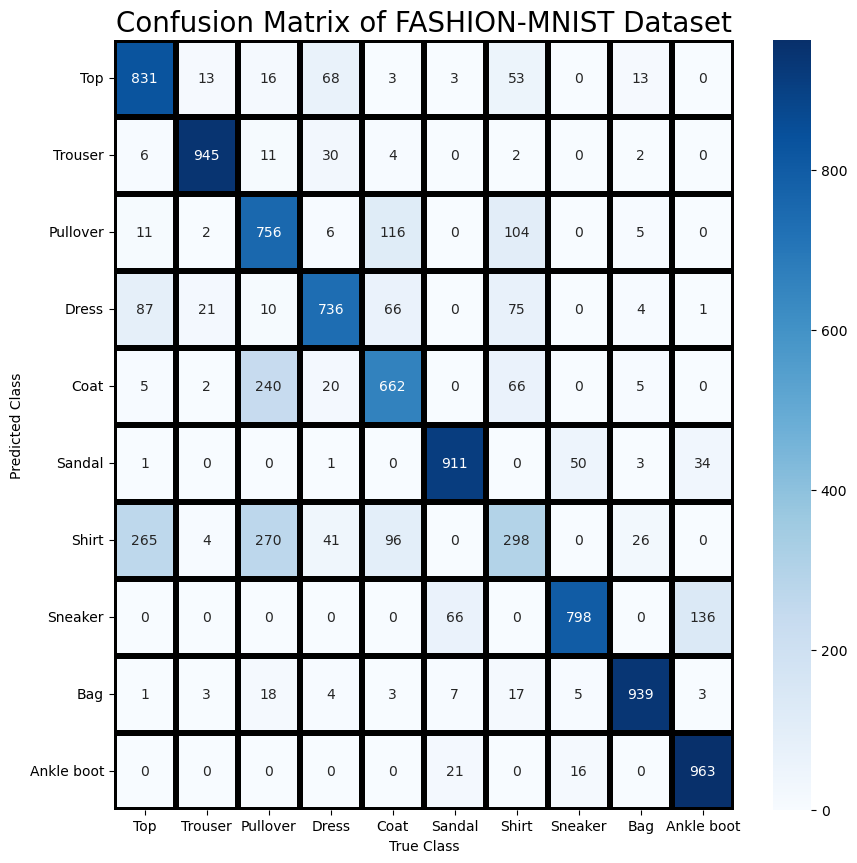

In [10]:
############################################################################################################################
# %%writefile confusion_matrix_plot.py
# Plot confusion matrix

import pickle
from keras.datasets import fashion_mnist
from sklearn import metrics
import numpy as np
import math
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Load the trained network
filename_model = 'neural_network.object'
network = pickle.load(open(filename_model, 'rb'))

(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

def softmax(pre_activation_vector):
    post_act = np.copy(pre_activation_vector)
    max_exponent = np.max(post_act)
    post_act = np.exp(post_act - max_exponent)
    post_act = post_act / np.sum(post_act)
    return post_act

def relu(pre_activation_vector):
    post_act = np.copy(pre_activation_vector)
    post_act[post_act < 0] = 0
    return post_act

def sigmoid_element_wise(vector_component):
    if vector_component >= 0:
        return 1 / (1 + math.exp(-vector_component))
    else:
        return math.exp(vector_component) / (math.exp(vector_component) + 1)

def sigmoid(pre_activation_vector):
    activated_vector = np.empty_like(pre_activation_vector)
    for i, elem in np.ndenumerate(pre_activation_vector):
        activated_vector[i] = sigmoid_element_wise(elem)
    return activated_vector

def activation_function(pre_activation_vector, context):
    if context == 'softmax':
        return softmax(pre_activation_vector)
    elif context == 'sigmoid':
        return sigmoid(pre_activation_vector)
    elif context == 'tanh':
        return np.copy(np.tanh(pre_activation_vector))
    elif context == 'relu':
        return relu(pre_activation_vector)
    else:
        return None

def forward_propagation(n, x):
    for i in range(n):
        if i == 0:
            network[i]['a'] = network[i]['weight'] @ x + network[i]['bias']
        else:
            network[i]['a'] = network[i]['weight'] @ network[i - 1]['h'] + network[i]['bias']
        network[i]['h'] = activation_function(network[i]['a'], context=network[i]['context'])

cm_plot_labels = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def predict_label(number_of_layer):
    acc = 0
    y_pred = []
    for x, y in zip(testX, testy):
        forward_propagation(number_of_layer, x.reshape(784, 1) / 255.0)
        max_prob = np.argmax(network[number_of_layer - 1]['h'])
        if max_prob == y:
            acc += 1
        y_pred.append(max_prob)
    print("Accuracy: ", str((acc / len(testy)) * 100), "%")
    cm = metrics.confusion_matrix(y_true=testy, y_pred=y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in cm_plot_labels], columns=[i for i in cm_plot_labels])
    print(df_cm)
    plt.figure(figsize=(10, 10))
    ax = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d', linewidths=3, linecolor='black')
    ax.set_yticklabels(cm_plot_labels, rotation=0)
    plt.xlabel("True Class")
    plt.ylabel("Predicted Class")
    plt.title('Confusion Matrix of FASHION-MNIST Dataset', fontsize=20)
    plt.show()

predict_label(len(network))


In [11]:
# # ############################################################################################################################
# # # %%writefile plot_images_fashion_mnist.py

from keras.datasets import fashion_mnist
import wandb

# Initialize Weights & Biases
wandb.init(project="Fashion-MNIST-Images", id="Question-1")

# Define class names for Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load the Fashion MNIST dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# Normalize pixel values to the range 0-1
trainX = trainX / 255.0
testX = testX / 255.0

def log_images():
    # Initialize lists to store images and their corresponding labels
    set_images = []
    set_labels = []
    count = 0  # Counter to keep track of how many images per class have been added
    for d in range(len(trainy)):
        if trainy[d] == count:
            # Add the image and its label to the respective lists
            set_images.append(trainX[d])
            set_labels.append(class_names[trainy[d]])
            count += 1
        else:
            pass
        if count == 10:
            break  # If images for all 10 classes have been collected, exit the loop

    # Log the images and their labels to Weights & Biases
    wandb.log({"Plot": [wandb.Image(img, caption=caption) for img, caption in zip(set_images, set_labels)]})

# Call the function to log images
log_images()


In [ ]:
# Define the sweep configuration

sweep_config = {
    
    "name": "my_custom_sweep",
    'method': 'grid',
    'parameters': {
        'epochs': {'values': [5, 10]},  # Add epochs parameter
        'num_layers': {'values': [3]},
#         'num_layers': {'values': [3, 4, 5]},
      
        'layer_1': {'values': [32, 64, 128]},
        'layer_2': {'values': [32, 64, 128]},
        'layer_3': {'values': [32, 64, 128]},
#         'layer_4': {'values': [32, 64, 128]},
#         'layer_5': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimiser': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64, 128, 256, 512]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']},
        'loss_type':{'values': ['cross_entropy', 'squared_error']}
    }
}


metric = {
    'name': 'val_accuracy',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric


# Initialize a sweep
sweep_id = wandb.sweep(sweep_config, project="CS6910_ASSIGNMENT_01")

# Define the sweep function
# def sweep():
#     with wandb.init() as run:
#         config = run.config
#         train()

def sweep():
    train()

# Initialize the sweep agent

wandb.agent(sweep_id, function=sweep, count=50)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: vkf69k6p
Sweep URL: https://wandb.ai/abhijeet001/CS6910_ASSIGNMENT_01/sweeps/vkf69k6p


wandb: Agent Starting Run: t7ujc01t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	layer_1: 32
wandb: 	layer_2: 32
wandb: 	layer_3: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	num_layers: 3
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Exception in thread Exception in thread Exception in thread IntMsgThrChkStopThrNetStatThr:
:
:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "C:\Users\OM\anaconda3\lib\threading.py", line 980, in _bootstrap_inner
  File "C:\Users\OM\anaconda3\lib\threading.py", line 980, in _bootstrap_inner
  File "C:\Users\OM\anaconda3\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\OM\anaconda3\lib\threading.py", line 917, in run
    self.run()    
    self.run()  File "C:\Users\OM\anaconda3\lib\threading.py", line 917, in run
self._target(*self._args, **self._kwargs)

  F

epochs,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▅▃▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▅▃▂▁
epochs,5
train_accuracy,0.10002
train_loss,3.08797
val_accuracy,0.10267
val_loss,3.07705


wandb: Agent Starting Run: z446ceof with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	layer_1: 32
wandb: 	layer_2: 32
wandb: 	layer_3: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	num_layers: 3
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epochs,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▅▃▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▅▃▂▁
epochs,5
train_accuracy,0.0996
train_loss,2.48349
val_accuracy,0.10267
val_loss,2.48407


wandb: Agent Starting Run: e1yvkun5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	layer_1: 32
wandb: 	layer_2: 32
wandb: 	layer_3: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	num_layers: 3
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


epochs,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▅▃▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▅▃▂▁
epochs,5
train_accuracy,0.10054
train_loss,2.97353
val_accuracy,0.09417
val_loss,3.00335


wandb: Agent Starting Run: edv2vpcf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	layer_1: 32
wandb: 	layer_2: 32
wandb: 	layer_3: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	num_layers: 3
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
